In [33]:
import array as arr
import numpy as np
import seaborn as sns
import pandas as pd
from numpy import percentile
from numpy.random import rand
from unicodedata import normalize
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import warnings
import io
import random
import h5py
import PIL
import os
import time
import re
import string
import PIL.Image
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__
import itertools
tf.compat.v1.enable_eager_execution()

from random import seed
seed(10)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [34]:
!pip install langdetect 
from langdetect import detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
# Mount the drive path housing the data

from google.colab import drive
drive.mount('/content/drive')
project_path = "/content/drive/My Drive/NLP Capstone Project Collaboration/Code/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Prepare a subset of the data for modeling

# Convert unicode characters to ascii
def unicode_to_ascii(s):
  s = normalize('NFD', s).encode('ascii', 'ignore')
  return s.decode('UTF-8')

# Detect language of sentence
def detect_language(text):
  try:
    lang = detect(text)
  except:
    lang = 'Unknown'
  return lang

def preprocess_sentence(w):
  #w = unicode_to_ascii(w.lower().strip())
    
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ." 
    
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
    
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # COMMENT THIS LINE FOR NON-LATIN SCRIPTS SUCH AS MARATHI, HINDI ETC.
    
  w = w.rstrip().strip()
    
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  #w = '<start> ' + w + ' <end>'

  return w

def take_user_input_for_num_of_records():
  num = input ("Enter number of records for sampling:")
  return int(num)

def EDA_and_sampling():
  os.chdir(r"/content/drive/My Drive/NLP Capstone Project Collaboration/Code/Dataset")

  print("Take user input for number of records for sampling. ")
  num = take_user_input_for_num_of_records()
  print("User requested for modeling with {} records.".format(num))
    
  with open('commoncrawl_de_en.txt', encoding='utf8') as f:
    commoncrawl_de_en = []
    for line in f:
      commoncrawl_de_en.append(line.strip())

  with open('commoncrawl_en_de.txt', encoding='utf8') as f:
    commoncrawl_en_de = []
    for line in f:
      commoncrawl_en_de.append(line.strip())

  with open('europarl-v7_de_en.txt', encoding='utf8') as f:
    europarl_v7_de_en = []
    for line in f:
      europarl_v7_de_en.append(line.strip())

  with open('europarl-v7_en_de.txt', encoding='utf8') as f:
    europarl_v7_en_de = []
    for line in f:
      europarl_v7_en_de.append(line.strip())

  with open('news-commentary-v9_de_en.txt', encoding='utf8') as f:
    news_commentary_v9_de_en = []
    for line in f:
      news_commentary_v9_de_en.append(line.strip())

  with open('news-commentary-v9_en_de.txt', encoding='utf8') as f:
    news_commentary_v9_en_de = []
    for line in f:
      news_commentary_v9_en_de.append(line.strip())

  print("Record in each file BEFORE EDA and cleansing")
  print("commoncrawl_de_en : ", len(commoncrawl_de_en))
  print("commoncrawl_en_de : ", len(commoncrawl_en_de))
  print("europarl_v7_de_en : ", len(europarl_v7_de_en))
  print("europarl_v7_en_de : ", len(europarl_v7_en_de))
  print("news_commentary_v9_de_en : ", len(news_commentary_v9_de_en))
  print("news_commentary_v9_en_de : ", len(news_commentary_v9_en_de))
    
  print("-------------------------------")
  print("\nReasons for not considering News_commentary dataset for pre-processing and modeling : \n    - The records counts are not matching between EN and DE dataset. \n    - Manual verification of an English sentence and translating it to German has resulted in non-perfect match and random appearance in dataset. \n    - The dataset cannot be used for modeling as the dependant and independant variables are non-related. \n")
    
  DE_EN_Full_list = commoncrawl_de_en + europarl_v7_de_en 
  EN_DE_Full_list = commoncrawl_en_de + europarl_v7_en_de 
  df_merged_full = pd.DataFrame({'DE_EN_list': DE_EN_Full_list, 'EN_DE_list': EN_DE_Full_list})
    
  print("-------------------------------")
  print("Setting parameters for pre-processing: \n\n    - Identify a subset of full dataset which has significant amount of words to create vocabulary.\n    - Considering only those sentences which have english-german translation. \n")
    
  df_merged_full['len_of_english_words'] = df_merged_full['EN_DE_list'].str.split().apply(len)
  df_merged_full['len_of_german_words'] = df_merged_full['DE_EN_list'].str.split().apply(len)
    
  print("-------------------------------")
  print("Quantile Distribution of English and German words:\n")
  print("\n5% of data is represented with : ", df_merged_full.quantile(0.05, axis=0))
  print("\n10% of data is represented with : ", df_merged_full.quantile(0.10, axis=0))
  print("\n15% of data is represented with : ", df_merged_full.quantile(0.15, axis=0))
  print("\n20% of data is represented with : ", df_merged_full.quantile(0.20, axis=0))
    
  print("-------------------------------")
  print("\n# Based on the above quantile distribution of words in English and German sentences, in order to get better results for machine translation, \n the english sentences with 1 to 7 words and the german sentences with 1 to 7 words will be taken into account for further exploration and modeling. \nThis is approximately covering 5% of data.")
    
  df_merged_subset = df_merged_full[(df_merged_full['len_of_english_words'] <= 7) & (df_merged_full['len_of_english_words'] > 0) 
                                  & (df_merged_full['len_of_german_words'] <= 7 )& (df_merged_full['len_of_german_words'] > 0)]
    
  # Checking existence of other languages in the dataset
  df_merged_subset['Language_DE_EN'] = df_merged_subset['DE_EN_list'].apply(detect_language)
  df_merged_subset['Language_EN_DE'] = df_merged_subset['EN_DE_list'].apply(detect_language)
  print(df_merged_subset.head(10))
    
  print("-------------------------------")
  print("\nSelecting records having English to German translation only. \n")
  new_df_train = df_merged_subset[(df_merged_subset['Language_DE_EN']=='de') & (df_merged_subset['Language_EN_DE']=='en')]
  print(new_df_train.shape)
    
  # Selecting dependant and independant attributes.
  new_df_train_final = new_df_train[['EN_DE_list','DE_EN_list']]
    
  new_df_train_final['EN_DE_list'] = new_df_train_final['EN_DE_list'].apply(preprocess_sentence)
  new_df_train_final['DE_EN_list'] = new_df_train_final['DE_EN_list'].apply(preprocess_sentence)
    
  print("Dimension of data available after merging and cleansing.\n ", new_df_train_final.shape)
      
  df = new_df_train_final.iloc[0:num,:]
    
  print("\nCreating csv file to dump user requested samples.\n ", df.shape)
  os.chdir(r"/content/drive/My Drive/NLP Capstone Project Collaboration/Code")
  df.to_csv('df_subset.csv')
    
  return df  

def data_preprocessing():
  df_sampled = EDA_and_sampling()
  return df_sampled

In [37]:
# Load and preprocess the data and create a subset for modeling purposes
data_preprocessing()

Take user input for number of records for sampling. 
Enter number of records for sampling:5000
User requested for modeling with 5000 records.
Record in each file BEFORE EDA and cleansing
commoncrawl_de_en :  2399123
commoncrawl_en_de :  2399123
europarl_v7_de_en :  1920209
europarl_v7_en_de :  1920209
news_commentary_v9_de_en :  201854
news_commentary_v9_en_de :  201995
-------------------------------

Reasons for not considering News_commentary dataset for pre-processing and modeling : 
    - The records counts are not matching between EN and DE dataset. 
    - Manual verification of an English sentence and translating it to German has resulted in non-perfect match and random appearance in dataset. 
    - The dataset cannot be used for modeling as the dependant and independant variables are non-related. 

-------------------------------
Setting parameters for pre-processing: 

    - Identify a subset of full dataset which has significant amount of words to create vocabulary.
    - Con

,EN_DE_list,DE_EN_list
3,Construction and repair of highways and . . .,Der Bau und die Reparatur der Autostraßen . . .
49,The potential productivity gains should be con...,Das am leichtesten zu erlernende professionell...
216,"Beautiful apartment in Chiclana , Cadiz for re...",Ferienappartment mit 3 Schlafzimmern für 6 Per...
248,// Get a file into an array .,// Liest eine Datei in ein Array .
358,Returns an array with 7 elements .,Gibt ein Array mit fünf Elementen zurück .
...,...,...
412229,Alessia Ventura was born in Turin 10/4/1980 .,Alessia Ventura wurde in Turin 10/4/1980 gebor...
412230,Alessia since child practical different sporti...,Alessia seit Kind praktische andere sportliche...
412307,Heard of you from a friend .,Habe durch einen Freund von Ihnen geh�rt .
412308,No other sites compare to yours .,Keine Website ist so gut wie Ihre .


In [38]:
# Read back the dataset that was saved earlier
nmt = pd.read_csv(project_path+'df_subset.csv')

In [39]:
print(nmt.head(5))
print(nmt.shape)

   Unnamed: 0                                         EN_DE_list  \
0           3      Construction and repair of highways and . . .   
1          49  The potential productivity gains should be con...   
2         216  Beautiful apartment in Chiclana , Cadiz for re...   
3         248                      // Get a file into an array .   
4         358                 Returns an array with 7 elements .   

                                          DE_EN_list  
0    Der Bau und die Reparatur der Autostraßen . . .  
1  Das am leichtesten zu erlernende professionell...  
2  Ferienappartment mit 3 Schlafzimmern für 6 Per...  
3                 // Liest eine Datei in ein Array .  
4         Gibt ein Array mit fünf Elementen zurück .  
(5000, 3)


In [40]:
nmt_lang = nmt[['EN_DE_list','DE_EN_list']]

In [41]:
import pickle
from string import punctuation
from collections import Counter, defaultdict
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Dropout
from nltk.translate.bleu_score import corpus_bleu

##################################################################
#########  <START> GENERIC FUNCTIONS USED ACROSS MODELS  #########
##################################################################

# Display accuracy/loss plots
def printPlots(results):
  # Let's plot training history of the best performing model as per the above trials
  print(results.history.keys())

  # Summarize history for accuracy
  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
  # Summarize history for loss
  plt.plot(results.history['loss'])
  plt.plot(results.history['val_loss'])
  #plt.ylim([0,6])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def print_bleu_plots(bleu_data):
  X = list(bleu_data.keys())
  Y = list(bleu_data.values())
    
  plt.bar(range(len(bleu_data)), height = Y)

  for i in range(len(bleu_data)):
    plt.text(i, Y[i], Y[i], ha = 'center')
        
  plt.title("BLEU Score:")
  plt.ylim((0,1))
  plt.show()

def displayAccuracy(model, X_train, X_test, y_train, y_test):
  print("Training model accuracy:", model.evaluate(X_train, y_train))
  print("Test model accuracy:", model.evaluate(X_test, y_test))

def predictSentence(model, spairs, inp_tokens, targ_tokens, inp_seq, index):
  print("The English sentence is: {}".format(spairs[index][0]))
  print("The German sentence is: {}".format(spairs[index][1]))

  def logits_to_sentence(logits, tokenizer):
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>' 

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

  print('The predicted sentence is :')
  print(logits_to_sentence(model.predict(inp_seq[index:index+1])[0], targ_tokens))

# Function to prepare Index to Word dictionaries
def FlipWordIndexDict(dict):
  Flippeddict = {}
  for w in dict:
    Flippeddict[dict[w]] = w

  return Flippeddict

# The below function converts the embedded form words to word indexes
def ConvertPredictionsToWordIndices(preds):
  PredictedWordIndex=np.arange(preds.shape[0]*preds.shape[1]).reshape(preds.shape[0],preds.shape[1])
  PredictedSentences= []
  # Iteration for each line
  for i in range(0,preds.shape[0]):    
    # Iteration for each word
    for j in range(0,preds.shape[1]):   
      # This dimention is equal to the target language corpus
      # Find the slot where probability is maximum - corresponding word is the word
      wi=0
      for k in range(0,preds.shape[2]):
        if preds[i][j][k] > preds[i][j][wi]:
          wi=k
      PredictedWordIndex[i,j]=wi

  return PredictedWordIndex

# The below function converts the word indices to words and forms the sentences
def ConvertSequencesToSentences(sequence, indexToWord):
  Sequences=[]
  for i in range(0,sequence.shape[0]):
    sentence=''
    for ind in sequence[i]:
      if sentence == '':
        sentence=str(indexToWord[ind+1])
      else:
        sentence=sentence+' '+str(indexToWord[ind+1])
    Sequences.append(sentence)

  return Sequences

##################################################################
##########  <END> GENERIC FUNCTIONS USED ACROSS MODELS  ##########
##################################################################

In [42]:
#########################################################################
#########  <START> MODEL 1: FUNCTIONS USED IN RNN + LSTM MODEL  #########
#########################################################################

def build_simple_RNN_LSTM_model(X_train, X_test, y_train, y_test, inp_tokens, targ_tokens, inp_vocab_size, targ_vocab_size, inp_length, targ_length):
  exec_start_time = time.time()

  # After making a number of trials, the following parameters are selected for the model training.
  NoOfNeurons = 512 
  Patience = 4
  Verbose = 1
  Epochs = 100
  BatchSize = 16
  LearningRate = 0.0001

  model = Sequential()
  model.add(Embedding(inp_vocab_size, NoOfNeurons, input_length=inp_length, mask_zero=True))
  model.add(LSTM(NoOfNeurons))
  model.add(RepeatVector(targ_length))
  model.add(LSTM(NoOfNeurons, return_sequences=True))
  model.add(Dense(targ_vocab_size, activation='softmax'))

  rms = optimizers.RMSprop(lr=LearningRate)
  model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ["accuracy"])

  callback = EarlyStopping(monitor='val_loss', patience=Patience, verbose=Verbose)

  print('\nModel Definition:')
  print(model.summary())

  print('\nModel compilation and fit parameters are:\n')
  print('Number of neurons used in layers: ', NoOfNeurons)
  print('Patience used is: ', Patience)
  print('Verbose set to: ', Verbose)
  print('RMS Learning Rate is set to: ', LearningRate)
  print('Number of epochs to be executed is: ', Epochs)
  print('Batch size set to: ', BatchSize)
  print('\n')

  f = model.fit(X_train, 
                y_train.reshape(y_train.shape[0], y_train.shape[1],1),
                validation_data = (X_test, y_test.reshape(y_test.shape[0], y_test.shape[1],1)),
                epochs=Epochs, 
                batch_size=BatchSize, 
                callbacks=[callback])

  # Let's plot training history of the best performing model as per the above trials
  # List all data keys in history
  print(f.history.keys())

  # Summarize history for accuracy
  plt.plot(f.history['accuracy'])
  plt.plot(f.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Summarize history for loss
  plt.plot(f.history['loss'])
  plt.plot(f.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Predictions - Translations by the model
    
  Predictions = model.predict(X_test)
    
  # Printing the shape of Predictions 
  print('The shape of Predictions is:', Predictions.shape)

  # Note: The predictions contain Target language words in Embedded form;
  # Observe that the last dimension is equal to the target vocabulary size implying the need for conversion of enbedded values 
  # for words back into word indices and then to sentences. The below code converts the Predictions into lines with words.
  EN_WordToIndex = inp_tokens.word_index
  DE_WordToIndex = targ_tokens.word_index
  
  # The Index to Word dictionaries
  EN_IndexToWord = FlipWordIndexDict(EN_WordToIndex)
  DE_IndexToWord = FlipWordIndexDict(DE_WordToIndex)

  # Converting Predictions into Word Indices form
  Predictions_WI = ConvertPredictionsToWordIndices(Predictions)

  # Converting Predicted Word Indexes into Words and Sentences
  PredictedSentences = ConvertSequencesToSentences(Predictions_WI, DE_IndexToWord)

  # Converting the corresponding Actual Word Indexes to Words and Sentences
  ActualSentences = ConvertSequencesToSentences(X_test, DE_IndexToWord)
    
  # Printing the First five Actual Target Language Sentences and 
  # corresponding Translated / Predicted Target Language Sentences for visual comparison
    
  print('\nThe Target Language ACTUAL SENTENCES:\n')
  for n in range(0,5):
    print(n, ActualSentences[n])
    
  print('\nThe Target Language PREDICTED/TRANSLATED SENTENCES:\n')
  for n in range(0,5):
    print(n, PredictedSentences[n])
        
  exec_end_time = time.time()
  print('Total Time taken by the module is: ', round(exec_end_time-exec_start_time,0), 'seconds')
    
  return model

#######################################################################
#########  <END> MODEL 1: FUNCTIONS USED IN RNN + LSTM MODEL  #########
#######################################################################

In [43]:
########################################################################################
#########  <START> MODEL 2: FUNCTIONS USED IN RNN + LSTM MODEL WITH EMBEDDING  #########
########################################################################################

def build_simple_RNN_LSTM_embeddings_model(X_train, X_test, y_train, y_test, inp_tokens, targ_tokens, inp_vocab_size, targ_vocab_size, inp_length, targ_length):
  exec_start_time = time.time()

  # Create embedding matrix using glove.6B.100d.txt.
  embeddings_index = dict()
  g = open(project_path+'Glove/glove.6B.100d.txt',"r", encoding="utf8", errors= "ignore")

  for line in g:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  g.close()
  print('Loaded %s word vectors.' % len(embeddings_index))

  # create a weight matrix for words in training docs
  embedding_matrix_eng = np.zeros((inp_vocab_size, 100))
  embedding_matrix_deu = np.zeros((targ_vocab_size, 100))
                                     
  for word, i in inp_tokens.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_eng[i] = embedding_vector
        
  for word, i in targ_tokens.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_deu[i] = embedding_vector

  # After making a number of trials, the following parameters are selected for the model training.
  NoOfNeurons = 512 
  Patience = 4
  Verbose = 1
  Epochs = 100
  BatchSize = 16
  LearningRate = 0.0001

  model = Sequential()
  model.add(Embedding(inp_vocab_size, 100, input_length=inp_length,weights = [embedding_matrix_eng], mask_zero=True))
  model.add(LSTM(NoOfNeurons))
  model.add(Dropout(0.2))
  model.add(RepeatVector(targ_length))
  model.add(LSTM(NoOfNeurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(targ_vocab_size, activation='softmax'))

  rms = optimizers.RMSprop(lr=LearningRate)
  model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ["accuracy"])

  callback = EarlyStopping(monitor='val_loss', patience=Patience, verbose=Verbose)

  print('\nModel Definition:')
  print(model.summary())

  print('\nModel compilation and fit parameters are:\n')
  print('Number of neurons used in layers: ', NoOfNeurons)
  print('Patience used is: ', Patience)
  print('Verbose set to: ', Verbose)
  print('RMS Learning Rate is set to: ', LearningRate)
  print('Number of epochs to be executed is: ', Epochs)
  print('Batch size set to: ', BatchSize)
  print('\n')

  f = model.fit(X_train, 
                y_train.reshape(y_train.shape[0], y_train.shape[1],1),
                validation_data = (X_test, y_test.reshape(y_test.shape[0], y_test.shape[1],1)),
                epochs=Epochs, 
                batch_size=BatchSize, 
                callbacks=[callback])

  # Let's plot training history of the best performing model as per the above trials
  # List all data keys in history
  print(f.history.keys())

  # Summarize history for accuracy
  plt.plot(f.history['accuracy'])
  plt.plot(f.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Summarize history for loss
  plt.plot(f.history['loss'])
  plt.plot(f.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Predictions - Translations by the model
    
  Predictions = model.predict(X_test)
    
  # Printing the shape of Predictions 
  print('The shape of Predictions is:', Predictions.shape)

  # Note: The predictions contain Target language words in Embedded form;
  # Observe that the last dimension is equal to the target vocabulary size implying the need for conversion of enbedded values 
  # for words back into word indices and then to sentences. The below code converts the Predictions into lines with words.
  EN_WordToIndex = inp_tokens.word_index
  DE_WordToIndex = targ_tokens.word_index
  
  # The Index to Word dictionaries
  EN_IndexToWord = FlipWordIndexDict(EN_WordToIndex)
  DE_IndexToWord = FlipWordIndexDict(DE_WordToIndex)

  # Converting Predictions into Word Indices form
  Predictions_WI = ConvertPredictionsToWordIndices(Predictions)

  # Converting Predicted Word Indexes into Words and Sentences
  PredictedSentences = ConvertSequencesToSentences(Predictions_WI, DE_IndexToWord)

  # Converting the corresponding Actual Word Indexes to Words and Sentences
  ActualSentences = ConvertSequencesToSentences(X_test, DE_IndexToWord)
    
  # Printing the First five Actual Target Language Sentences and 
  # corresponding Translated / Predicted Target Language Sentences for visual comparison
    
  print('\nThe Target Language ACTUAL SENTENCES:\n')
  for n in range(0,5):
    print(n, ActualSentences[n])
    
  print('\nThe Target Language PREDICTED/TRANSLATED SENTENCES:\n')
  for n in range(0,5):
    print(n, PredictedSentences[n])
        
  exec_end_time = time.time()
  print('Total Time taken by the module is: ', round(exec_end_time-exec_start_time,0), 'seconds')
    
  return model

########################################################################################
#########  <END> MODEL 2: FUNCTIONS USED IN RNN + LSTM MODEL WITH EMBEDDING  ###########
########################################################################################

In [44]:
#######################################################################
########  <START> MODEL 3: FUNCTIONS USED IN BIDIR LSTM MODEL  ########
#######################################################################

# Load the dataframe corresponding to the language dataset
def load_data(df):
  sentence_pairs = []
  for index, row in df.iterrows():
    s1 = row['EN_DE_list']
    s2 = row['DE_EN_list']
    sentence_pairs.append([s1, s2])
  return sentence_pairs

# Get maximum length of a sentence
def max_length(sentences):
  lengths = [len(s.split()) for s in sentences]
  return max(lengths)

def clean(string):
  # Clean the string
  string = string.replace("\u202f"," ") # Replace no-break space with space
  string = string.lower()
    
  # Delete the punctuation and the numbers
  for p in punctuation + "«»" + "0123456789":
    string = string.replace(p," ")
        
  string = re.sub('\s+',' ', string)
  string = string.strip()
           
  return string

# Apply regexp and other cleaning on a given sentence
def clean_sentence(sentence, regexp=0, convert2lc=0, unicode2ascii=0):
  if (convert2lc):
    if (unicode2ascii):
      sentence = unicode_to_ascii(sentence.lower().strip())
    else:
      sentence = sentence.lower().strip()
  else:
    sentence = sentence.strip()

  if (regexp):
    # creating a space between a word and the punctuation following it. Ex: "This is NMT." => "This is NMT ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    #sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.rstrip().strip()

  #clean(sentence)
  return sentence

# Filter sentence pairs based on lengths
def filter(sentence_pairs, Tx, Ty):
  lengths = [[len(s1.split()), len(s2.split())] for s1,s2 in sentence_pairs]
  good = [ True if (l1 <= Tx) and (l2 <= Ty) else False for l1,l2 in lengths]
  filtered = [s for i,s in enumerate(sentence_pairs) if good[i]]
  return filtered

# Tokenize words
def tokenize(lines):
  tokenizer = Tokenizer(filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n', lower=False)
  tokenizer.fit_on_texts(lines)
  return tokenizer

# Create encoded sequences with padding, from tokenized words
def create_sequence(tokens, length, slist):
  seq=tokens.texts_to_sequences(slist)
  seq=pad_sequences(seq, maxlen=length, padding='post')
  return seq

# Preprocess the sentences
def preprocess(sentences):
  tokens = tokenize(sentences)
  lang_max_length = max_length(sentences)
  seq = create_sequence(tokens, lang_max_length, list(sentences))
  return tokens, seq, lang_max_length

# Prepare the data for input to modeling
def prepare_data(sentence_pairs, applyFilter=0, num_examples=0, Tx=7, Ty=7):
  clean_sentence_pairs = [[clean_sentence(s1, 1), clean_sentence(s2, 1)] for s1,s2 in sentence_pairs]
  if (applyFilter):
    clean_sentence_pairs = filter(clean_sentence_pairs, Tx, Ty)
  if num_examples > 0:
    clean_sentence_pairs = clean_sentence_pairs[0:num_examples]
  inp_sentences = [s1 for s1, s2 in clean_sentence_pairs]
  targ_sentences = [s2 for s1, s2 in clean_sentence_pairs]
  inp_tokens, inp_seq, inp_length = preprocess(inp_sentences)
  targ_tokens, targ_seq, targ_length = preprocess(targ_sentences)
  print('Maximum length of English sentences: {}'.format(inp_length))
  print('Maximum length of German sentences: {}'.format(targ_length))
  print("English vocabulary is of {} unique words".format(len(inp_tokens.word_index)+1))
  print("German vocabulary is of {} unique words".format(len(targ_tokens.word_index)+1))
  return clean_sentence_pairs, inp_tokens, targ_tokens, inp_seq, targ_seq, inp_length, targ_length

# Split the dataset into train/test
def splitTrainTest(inp_seq, targ_seq):
  X_train, X_test, y_train, y_test = train_test_split(inp_seq, targ_seq, test_size=0.20, random_state=0)
  print("Shape of X_train:", X_train.shape)
  print("Shape of y_train:", y_train.shape)
  print("Shape of X_test:", X_test.shape)
  print("Shape of y_test:", y_test.shape)

  return X_train, X_test, y_train, y_test

# Build the model.
# Let’s make a sequential model now with the first layer as the word embedding layer. Then, let's apply bidirectional LSTM, where parameter return_sequence is marked as True 
# so that the word generation keeps in consideration both previous and the words coming ahead in the sequence. A dropout layer is added to avoid overfitting.
# The output layer has softmax so as to get the probability of the word to be predicted next.
def build_bidir_RNN_LSTM_model(X_train, X_test, y_train, y_test, inp_vocab_size, targ_vocab_size, inp_length, targ_length):
  print("Creating the bidirectional LSTM model ...")
  model = Sequential()
  model.add(Embedding(inp_vocab_size, 16, input_length=inp_length))
  # Adding Bidirectional LSTM layers
  model.add(Bidirectional(LSTM(512, return_sequences=True, dropout = 0.1)))
  model.add(Bidirectional(LSTM(512, return_sequences=True, dropout = 0.1)))
  model.add(Dense(targ_vocab_size, activation='softmax'))
  model.compile(loss='mse', optimizer='rmsprop')
  rms = optimizers.RMSprop(learning_rate=0.0001)

  #opt = tf.keras.optimizers.Adam(
  #        learning_rate=0.0001,
  #        beta_1=0.9,
  #        beta_2=0.999,
  #        epsilon=1e-07,
  #        amsgrad=False
  #      )

  # Compile the model
  print("Compiling the model ...")
  model.compile(optimizer=rms, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  # Print model summary
  print("Printing model summary ...")
  model.summary()

  # Fit the model
  print("Fitting the model ...")
  cb = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4, restore_best_weights=True)
  f = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), 
                batch_size=16, epochs=100, 
                validation_data = (X_test, y_test.reshape(y_test.shape[0], y_test.shape[1],1)), 
                callbacks=[cb],
                verbose=1)
  print(f.history)

  # Display the accuracy/loss plots
  printPlots(f)

  # Evaluate the model
  print("Evaluating the model ...")
  res = model.evaluate(X_test, y_test)
  print(res)

  return model

# Save the sentence paris in a dictionary
def save_pairs_dict(sentence_pairs):
  inp_ref_dict = {}
  for s1,s2 in sentence_pairs:
    inp_ref_dict[s1] = s2
   # print(s1, " | ", inp_ref_dict.get(s1))
  
  return inp_ref_dict

# Get the word from its tokenized index
def word_for_id(integer, tokenizer):
  # Map an integer to a word
  for word, index in tokenizer.word_index.items():
  #  print("word: ", word)
   # print("index, integer: ", index, integer)
    if index == integer:
      return word

  return None

# Get the raw sentence from its encoded counterpart
def get_sentence(tokenizer, source, predict_mode=False):
  sentence = list()
  if (predict_mode):
    integers = [np.argmax(vector) for vector in source]
  else:
    integers = source

#  print(integers)
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    sentence.append(word)

  return ' '.join(sentence)

# Generate target from a source sequence
def predict_seq(model, tokenizer, source, predict_mode=True):
 # print("in predict_seq")
  prediction = model.predict(source, verbose=0)[0]
  sentence = get_sentence(tokenizer, prediction, predict_mode)

  return sentence

# Compare original source and target sentences with their translated/predicted sentences
def compare_prediction(model, inp_tokenizer, targ_tokenizer, sources, pairs_dict, limit=20):
  #print("in compare_pred")
  source_str, target_str = "English", "German"
  src = f'{source_str.upper()} (SOURCE)'
  tgt = f'{target_str.upper()} (TARGET)'
  pred = f'TRANSLATED TO {target_str.upper()}'
  print(f'{src:30} | {tgt:25} | {pred}\n')
  
  # Translate encoded source text
  for i, source in enumerate(sources):
    orig_source = get_sentence(inp_tokenizer, source, False)
    orig_target = pairs_dict.get(orig_source)
    if (orig_target is None):
      continue
    source = source.reshape((1, source.shape[0]))
    translation = predict_seq(model, targ_tokenizer, source)
    print(f'{orig_source:30} | {orig_target:25} | {translation}')
    if i >= limit: # Display some of the results
      break

# Get the bleu score of a model
def bleu_score(model, inp_tokenizer, targ_tokenizer, sources, pairs_dict):
  actual, predicted = [], []
  for i, source in enumerate(sources):
    # Translate encoded source text
    orig_source = get_sentence(inp_tokenizer, source, False)
    orig_target = pairs_dict.get(orig_source)
    if (orig_target is None):
      continue
    source = source.reshape((1, source.shape[0]))
    translation = predict_seq(model, targ_tokenizer, source)
    actual.append([orig_target.split()])
    predicted.append(translation.split())
        
  bleu_dic = {}
  bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
  bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
  return bleu_dic

#######################################################################
#########  <END> MODEL 3: FUNCTIONS USED IN BIDIR LSTM MODEL  #########
#######################################################################

In [45]:
###################################################################################
#########  <START> MODEL 4: FUNCTIONS USED IN ENCODER/DECODER LSTM MODEL  #########
###################################################################################

def read_data(file):
  lines = pd.read_csv(file)
  #print (lines.head(5))
  #print (lines.shape)
  return lines

def prep_data(lines):
  lines.DE_EN_list = lines.DE_EN_list.apply(lambda x: 'START_' + ' ' + x + ' ' + '_END')
  lines = lines[['EN_DE_list', 'DE_EN_list']]
  #print(lines.head())
  return lines

def build_vocab(lines):
  # collecting all unique english words to create a vocabulary
  all_english_words = set()
  for eng in lines.EN_DE_list:
    for word in eng.split():
      if word not in all_english_words:
        all_english_words.add(word)

  # collecting all unique german words to create a vocabulary
  all_german_words = set()
  for de in lines.DE_EN_list:
    for word in de.split():
      if word not in all_german_words:
        all_german_words.add(word)
  return all_english_words, all_german_words

def sent_length(lines):
  # getting maximum sentence length of english sentences
  length_list = []
  for l in lines.EN_DE_list:
    length_list.append(len(l.split(' ')))

  max_input_length = np.max(length_list)
  print('Max English sentence length: ', max_input_length)

  # getting maximum sentence length of german sentences
  length_list = []
  for l in lines.DE_EN_list:
    length_list.append(len(l.split(' ')))

  max_output_length = np.max(length_list)
  print('Max German sentence length: ', max_output_length)

  return max_input_length, max_output_length

def enc_dec(lines, all_english_words, all_german_words, max_input_length, max_output_length):
  # making a list of all input and output words and sorting them out
  input_words = sorted(list(all_english_words))
  output_words = sorted(list(all_german_words))

  # getting total tokens(words) from input and otput
  num_encoder_tokens = len(all_english_words)
  num_decoder_tokens = len(all_german_words)
  print('encoder tokens: ', num_encoder_tokens)
  print('decoder tokens: ', num_encoder_tokens)

  # getting index for words as these indexes will behave as words for machine interactions
  input_token_index = dict([(word,i) for i,word in enumerate(input_words)])
  output_token_index = dict([(word,i) for i,word in enumerate(output_words)])

  print('input token index: ', input_token_index)
  print('output token index: ', output_token_index)

  # creating arrays of input and output data
  encoder_input_data = np.zeros((len(lines.EN_DE_list), max_input_length), dtype='float32')
  decoder_input_data = np.zeros((len(lines.DE_EN_list), max_output_length), dtype='float32')

  # one hot encoding the target data as Dense layer only gives one output through softmax layer
  decoder_target_data = np.zeros((len(lines.DE_EN_list), max_output_length, num_decoder_tokens))

  print(encoder_input_data.shape)
  print(decoder_input_data.shape)
  print(decoder_target_data.shape)

  # putting all the integer values in input, output data and target data
  for i,(input_text, output_text) in enumerate(zip(lines.EN_DE_list, lines.DE_EN_list)):
    for t, word in enumerate(input_text.split()):
      encoder_input_data[i,t] = input_token_index[word]
    for t,word in enumerate(output_text.split()):
      decoder_input_data[i,t] = output_token_index[word]
    # as decoder target data is ahead of decoder input data, it will not include start_ character (which will be given to decoder model at prediction)
      if t > 0:
        decoder_target_data[i,t-1,output_token_index[word]] = 1

  print("encoder input data: ", encoder_input_data[1])
  print('decoder input data: ', decoder_input_data[1])
  print('decoder target data: ', decoder_target_data[1])
  print('Shape of sample decoder target data: ', decoder_target_data[1].shape)

  return num_encoder_tokens, num_decoder_tokens, encoder_input_data, decoder_input_data, decoder_target_data,input_token_index, output_token_index

# function to predict translation
def decode_seq(encoder_model, decoder_model, reverse_output_char_index, input_seq, output_token_index):
  state_values = encoder_model.predict(input_seq)
  target_seq = np.zeros((1,1))
  target_seq[0,0] = output_token_index['START_']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + state_values)

    sampled_token_index = np.argmax(output_tokens[0,-1,:])
    sampled_char = reverse_output_char_index[sampled_token_index]

    decoded_sentence += ' ' + sampled_char

    if(sampled_char == '_END' or len(decoded_sentence) > 52):
      stop_condition = True

    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    state_values = [h,c] 

  return decoded_sentence

# testing the model for a sample from existing data
def predict_model(lines, encoder_input_data, encoder_model, decoder_model, output_token_index, reverse_output_char_index, dat):
  for seq_index in dat:
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentence = decode_seq(encoder_model, decoder_model, reverse_output_char_index, input_seq, output_token_index)
    print('----')
    print('Input_sentence: ', lines.EN_DE_list[seq_index:seq_index+1])
    print('decoded sentence: ', decoded_sentence)

def build_encdec_model(num_encoder_tokens, num_decoder_tokens, encoder_input_data, decoder_input_data, decoder_target_data, input_token_index, output_token_index):
  # building model for training stage
  embedding_size = 120
  lstm_dim = 324
  
  # encoder model
  encoder_inputs = Input(shape=(None,))
  en_x = Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
  encoder = LSTM(lstm_dim, return_state=True)
  encoder_outputs, state_h, state_c = encoder(en_x)
  encoder_states = [state_h, state_c]

  # decoder model
  decoder_inputs = Input(shape=(None,))
  final_dex = Embedding(num_decoder_tokens, embedding_size)(decoder_inputs)
  decoder_lstm = LSTM(lstm_dim, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)
  decoder_dense = Dense(num_decoder_tokens, activation='softmax') 
  decoder_outputs = decoder_dense(decoder_outputs)

  #opt = tf.keras.optimizers.Adam(
  #        learning_rate=0.0001,
  #        beta_1=0.9,
  #        beta_2=0.999,
  #        epsilon=1e-07,
  #        amsgrad=False
  #      )
  
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()
  f = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=30, validation_split=0.20)

  # Display the accuracy/loss plots
  printPlots(f)

  # Inference Stage
  # encoder model
  encoder_model = Model(encoder_inputs, encoder_states)
  encoder_model.summary()

  # decoder model
  decoder_state_input_h = Input(shape=(lstm_dim,))
  decoder_state_input_c = Input(shape=(lstm_dim,))
  decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

  final_dex2 = Embedding(num_decoder_tokens, embedding_size)(decoder_inputs)

  decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_state_inputs)
  decoder_states2 = [state_h2, state_c2]
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states2)

  # reversing the word index dictionary to get words from index values
  reverse_input_char_index = dict((i,char) for char, i in input_token_index.items())
  reverse_output_char_index = dict((i,char) for char, i in output_token_index.items())
  print(reverse_input_char_index)
  print(reverse_output_char_index)

  return encoder_model, decoder_model, reverse_output_char_index

def build_encdec_RNN_LSTM_model(lines):
  lines = prep_data(lines)
  eng_wrd, de_wrd = build_vocab(lines)
  print ("English words:" , len(eng_wrd)) 
  print ("German words: " , len(de_wrd))

  in_len, out_len = sent_length(lines)
  num_encoder_tokens, num_decoder_tokens, encoder_input_data, decoder_input_data, decoder_target_data, input_token_index, output_token_index = enc_dec(lines, eng_wrd, de_wrd, in_len, out_len)

  encoder_model, decoder_model, reverse_output_char_index = build_encdec_model(num_encoder_tokens, num_decoder_tokens, 
                                                                               encoder_input_data, decoder_input_data, decoder_target_data, 
                                                                               input_token_index, output_token_index)

  return encoder_input_data, encoder_model, decoder_model, reverse_output_char_index, output_token_index

########################################################################
#########  <END> FUNCTIONS USED IN ENCODER/DECODER LSTM MODEL  #########
########################################################################

In [46]:
# Perform the modeling
def doModeling(nmt_lang, modelType):
  if (modelType == 1 or modelType == 2 or modelType == 3):
    spairs = load_data(nmt_lang)
    print("Loading the dataset for modeling ...")
    print("  ... printing some sentence pairs (English, German)")
    print(spairs[0])
    print(spairs[1])
    print(spairs[2])
    print(spairs[3])
    print("Number of sentence pairs in the dataset:", len(spairs))
    clean_sentence_pairs, inp_tokens, targ_tokens, inp_seq, targ_seq, inp_length, targ_length = prepare_data(spairs)
    pairs_dict = save_pairs_dict(clean_sentence_pairs)
    inp_vocab_size = len(inp_tokens.word_index)+1
    targ_vocab_size = len(targ_tokens.word_index)+1

    # Split the data into train/test
    X_train, X_test, y_train, y_test = splitTrainTest(inp_seq, targ_seq)
  
  # Build and evaluate the model
  if (modelType == 1):
    model = build_simple_RNN_LSTM_model(X_train, X_test, y_train, y_test, inp_tokens, targ_tokens, inp_vocab_size, targ_vocab_size, inp_length, targ_length)
  elif (modelType == 2):
    model = build_simple_RNN_LSTM_embeddings_model(X_train, X_test, y_train, y_test, inp_tokens, targ_tokens, inp_vocab_size, targ_vocab_size, inp_length, targ_length)
  elif (modelType == 3):
    model = build_bidir_RNN_LSTM_model(X_train, X_test, y_train, y_test, inp_vocab_size, targ_vocab_size, inp_length, targ_length)
  else:
    lines = read_data(project_path+"df_subset.csv")
    encoder_input_data, encoder_model, decoder_model, reverse_output_char_index, output_token_index = build_encdec_RNN_LSTM_model(lines)

    # Predict on some input data indices
    dat = [123, 1234, 2345, 3456, 4567]
    predict_model(lines, encoder_input_data, encoder_model, decoder_model, output_token_index, reverse_output_char_index, dat)
  
  if (modelType == 1 or modelType == 2 or modelType == 3):
     # Display accuracy of model
    displayAccuracy(model, X_train, X_test, y_train, y_test)

    # Test on some training sequences
    print("\n\n### Result on the Training Set ###")
    compare_prediction(model, inp_tokens, targ_tokens, X_train, pairs_dict)

    # Test on some test sequences
    print("\n\n### Result on the Test Set ###")
    compare_prediction(model, inp_tokens, targ_tokens, X_test, pairs_dict)

    # Compute the BLEU Score
    print("\n\nCalculating BLEU score for the model")
    bleu_train = bleu_score(model, inp_tokens, targ_tokens, X_train, pairs_dict)
    bleu_test = bleu_score(model, inp_tokens, targ_tokens, X_test, pairs_dict)
    print("BLEU score for training set:")
    print_bleu_plots(bleu_train)
    print("BLEU score for test set:")
    print_bleu_plots(bleu_test)

    return model

In [47]:
# Try all the 4 models in sequence and then pick the best model based on BLEU score.

def runModels():
  print("START: Modeling simple RNN + LSTM ...")
  model1 = doModeling(nmt_lang, 1) # call simple RNN + LSTM model
  print("END: Modeling simple RNN + LSTM ...")
  
  print("\n\nSTART: Modeling simple RNN + LSTM with embeddings ...")
  model2 = doModeling(nmt_lang, 2) # call simple RNN + LSTM model with embeddings
  print("END: Modeling simple RNN + LSTM with embeddings ...")
  
  print("\n\nSTART: Modeling bidirectional RNN + LSTM ...")
  model3 = doModeling(nmt_lang, 3) # call bidir model
  print("END: Modeling bidirectional RNN + LSTM ...")

  print("\n\nSTART: Modeling encoder/decoder RNN + LSTM ...")
  model4 = doModeling(nmt_lang, 4) # call encoder/decoder model
  print("END: Modeling encoder/decoder RNN + LSTM ...")

  return model1, model2, model3, model4

START: Modeling simple RNN + LSTM ...
Loading the dataset for modeling ...
  ... printing some sentence pairs (English, German)
['Construction and repair of highways and . . .', 'Der Bau und die Reparatur der Autostraßen . . .']
['The potential productivity gains should be considerable .', 'Das am leichtesten zu erlernende professionelle Layoutwerkzeug .']
['Beautiful apartment in Chiclana , Cadiz for rent .', 'Ferienappartment mit 3 Schlafzimmern für 6 Personen .']
['// Get a file into an array .', '// Liest eine Datei in ein Array .']
Number of sentence pairs in the dataset: 5000
Maximum length of English sentences: 16
Maximum length of German sentences: 16
English vocabulary is of 7960 unique words
German vocabulary is of 9359 unique words
Shape of X_train: (4000, 16)
Shape of y_train: (4000, 16)
Shape of X_test: (1000, 16)
Shape of y_test: (1000, 16)

Model Definition:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)             

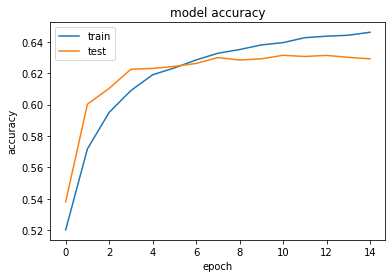

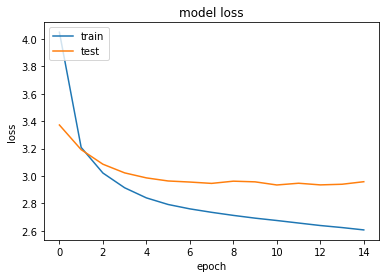

The shape of Predictions is: (1000, 16, 9359)

The Target Language ACTUAL SENTENCES:

0 Die benachrichtigt alles kann ist benachrichtigt beide ? . . . . . . . .
1 werden erstellt mit ist wird Werde Kopfschmerz Slideshows . . . . . . . .
2 Zimmer einen jedes neue nützlich Ihnen Boden ? . . . . . . . .
3 Hotel einen konnte Nachtleben ein JUSQUE Häkchen ? . . . . . . . .
4 alle Toskana ! seine nicht konnte Slideshows . . . . . . . . .

The Target Language PREDICTED/TRANSLATED SENTENCES:

0 ein von von für für für ? ? . . . . . . . .
1 wird zu in Der und eine eine neue . . . . . . . .
2 ein von Sie für für den ? ? . . . . . . . .
3 ein von Sie für die die ? ? . . . . . . . .
4 von von der der sein neue neue neue . . . . . . . .
Total Time taken by the module is:  163.0 seconds
125/125 [==============================] - 2s 7ms/step - loss: 2.5695 - accuracy: 0.6465
Training model accuracy: [2.5694899559020996, 0.6464687585830688]
32/32 [==============================] - 2s 8ms/step - loss: 

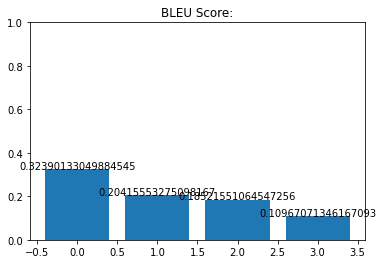

BLEU score for test set:


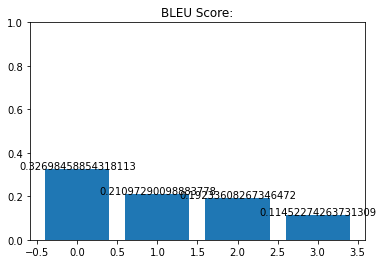

END: Modeling simple RNN + LSTM ...


START: Modeling simple RNN + LSTM with embeddings ...
Loading the dataset for modeling ...
  ... printing some sentence pairs (English, German)
['Construction and repair of highways and . . .', 'Der Bau und die Reparatur der Autostraßen . . .']
['The potential productivity gains should be considerable .', 'Das am leichtesten zu erlernende professionelle Layoutwerkzeug .']
['Beautiful apartment in Chiclana , Cadiz for rent .', 'Ferienappartment mit 3 Schlafzimmern für 6 Personen .']
['// Get a file into an array .', '// Liest eine Datei in ein Array .']
Number of sentence pairs in the dataset: 5000
Maximum length of English sentences: 16
Maximum length of German sentences: 16
English vocabulary is of 7960 unique words
German vocabulary is of 9359 unique words
Shape of X_train: (4000, 16)
Shape of y_train: (4000, 16)
Shape of X_test: (1000, 16)
Shape of y_test: (1000, 16)
Loaded 400000 word vectors.

Model Definition:
Model: "sequential_5"
__________

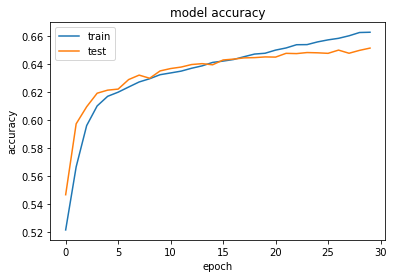

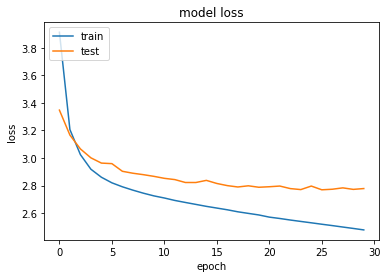

The shape of Predictions is: (1000, 16, 9359)

The Target Language ACTUAL SENTENCES:

0 Die benachrichtigt alles kann ist benachrichtigt beide ? . . . . . . . .
1 werden erstellt mit ist wird Werde Kopfschmerz Slideshows . . . . . . . .
2 Zimmer einen jedes neue nützlich Ihnen Boden ? . . . . . . . .
3 Hotel einen konnte Nachtleben ein JUSQUE Häkchen ? . . . . . . . .
4 alle Toskana ! seine nicht konnte Slideshows . . . . . . . . .

The Target Language PREDICTED/TRANSLATED SENTENCES:

0 benachrichtigt Slideshows erstellt du wenn ist ? ? . . . . . . . .
1 wird zu in Der und und eine neue . . . . . . . .
2 Ihr von sein sein sein den ? ? . . . . . . . .
3 ein die die die die die ? ? . . . . . . . .
4 Hotel mit mit mit über über neue neue . . . . . . . .
Total Time taken by the module is:  213.0 seconds
125/125 [==============================] - 2s 7ms/step - loss: 2.3854 - accuracy: 0.6718
Training model accuracy: [2.3853745460510254, 0.6717812418937683]
32/32 [===========================

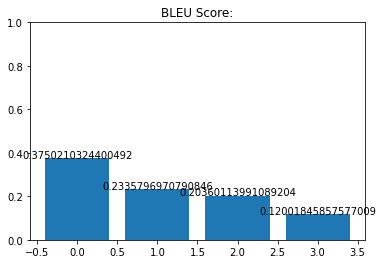

BLEU score for test set:


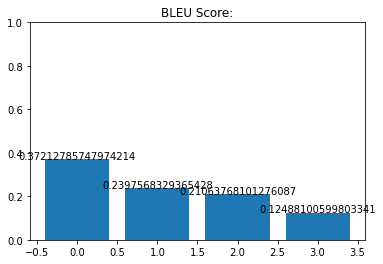

END: Modeling simple RNN + LSTM with embeddings ...


START: Modeling bidirectional RNN + LSTM ...
Loading the dataset for modeling ...
  ... printing some sentence pairs (English, German)
['Construction and repair of highways and . . .', 'Der Bau und die Reparatur der Autostraßen . . .']
['The potential productivity gains should be considerable .', 'Das am leichtesten zu erlernende professionelle Layoutwerkzeug .']
['Beautiful apartment in Chiclana , Cadiz for rent .', 'Ferienappartment mit 3 Schlafzimmern für 6 Personen .']
['// Get a file into an array .', '// Liest eine Datei in ein Array .']
Number of sentence pairs in the dataset: 5000
Maximum length of English sentences: 16
Maximum length of German sentences: 16
English vocabulary is of 7960 unique words
German vocabulary is of 9359 unique words
Shape of X_train: (4000, 16)
Shape of y_train: (4000, 16)
Shape of X_test: (1000, 16)
Shape of y_test: (1000, 16)
Creating the bidirectional LSTM model ...
Compiling the model ...
Printi

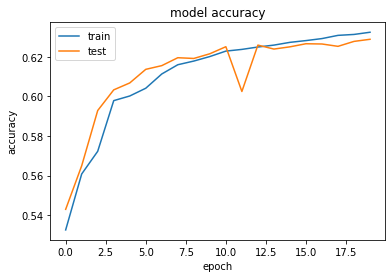

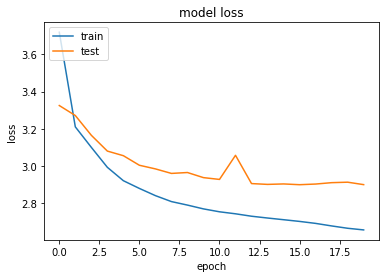

Evaluating the model ...
32/32 [==============================] - 2s 10ms/step - loss: 2.8981 - accuracy: 0.6266
[2.898120880126953, 0.6266250014305115]
125/125 [==============================] - 1s 10ms/step - loss: 2.6605 - accuracy: 0.6316
Training model accuracy: [2.66052508354187, 0.6315624713897705]
32/32 [==============================] - 0s 9ms/step - loss: 2.8981 - accuracy: 0.6266
Test model accuracy: [2.898120880126953, 0.6266250014305115]


### Result on the Training Set ###
ENGLISH (SOURCE)               | GERMAN (TARGET)           | TRANSLATED TO GERMAN

Swimming classes are available at extra charge . | Schwimmunterricht wird gegen eine Gebühr erteilt . | Die Sie ist und und und . .
There's an endless amount of dive sites ! | Es gibt eine endlose Anzahl an Tauchgebieten . | Die Sie ist in und und . .
How does Europa Casino protect my privacy ? | Wie sch�tzt das Europa Casino meine Privatsph�re ? | Wie Sie ich die die von ? ?
What is the Distribution Partner Programme ? |

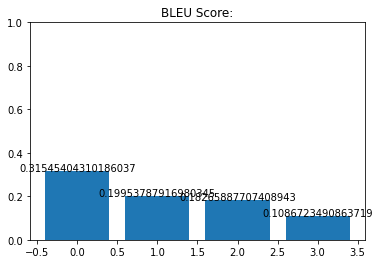

BLEU score for test set:


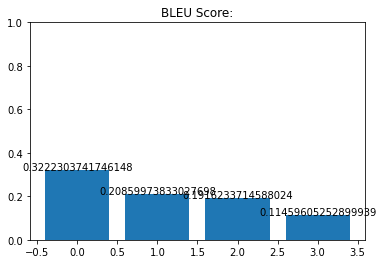

END: Modeling bidirectional RNN + LSTM ...


START: Modeling encoder/decoder RNN + LSTM ...
English words: 8063
German words:  9417
Max English sentence length:  16
Max German sentence length:  18
encoder tokens:  8063
decoder tokens:  8063
input token index:  {'!': 0, '#1': 1, '#38874': 2, '#gentoo': 3, '$3': 4, '$50': 5, '&': 6, '&nbsp&nbsp&nbsp': 7, "'How": 8, "'SO_REUSEADDR": 9, "'admin'": 10, "'andorra'": 11, "'brazil'": 12, "'cambodia'": 13, "'china'": 14, "'computer'": 15, "'download'": 16, "'eyecatcher'": 17, "'icq'": 18, "'japanese'": 19, "'laplink'": 20, "'milano'": 21, "'mostar'": 22, "'norway'": 23, "'s": 24, "'tennis'": 25, "'video'": 26, "'xdcc'": 27, '(': 28, '(0': 29, '(1)': 30, '(1910)': 31, '(2000)': 32, '(2004)': 33, '(5': 34, '(A': 35, '(ADNM)': 36, '(AHC)': 37, '(C8H10O2N4': 38, '(Darkshore)': 39, '(Germany)': 40, '(Guaguas)': 41, '(Hz)': 42, '(JQS)': 43, '(JRE)': 44, '(Kyriakos': 45, '(OCR)': 46, '(PDF)': 47, '(Producer:': 48, '(SMU)': 49, '(Target)': 50, '(Unicod

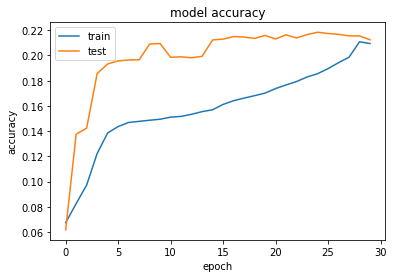

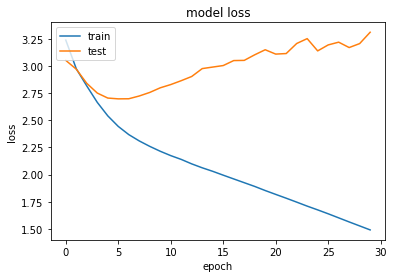

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 120)         967560    
                                                                 
 lstm_14 (LSTM)              [(None, 324),             576720    
                              (None, 324),                       
                              (None, 324)]                       
                                                                 
Total params: 1,544,280
Trainable params: 1,544,280
Non-trainable params: 0
_________________________________________________________________
{0: '!', 1: '#1', 2: '#38874', 3: '#gentoo', 4: '$3', 5: '$50', 6: '&', 7: '&nbsp&nbsp&nbsp', 8: "'How", 9: "'SO_REUSEADDR", 10: "'admin'", 11: "'andorra'", 12: "'brazil'", 13: "'ca

In [48]:
# Run all the models

model1, model2, model3, model4 = runModels()

In [51]:
# Pickle the best model

import joblib

joblib_file = project_path+"NLP.pkl"  
joblib.dump(model2, joblib_file)

['/content/drive/My Drive/NLP Capstone Project Collaboration/Code/NLP.pkl']